In this notebook, we explore our cleaned data set and make/test hypotheses using code and plots

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/Users/rvg/miniconda2/envs/tutorial/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
# First let's load in our data set for the city of LA. This includes both electricity demand and weather data
df = pd.read_pickle('LA_df.pklb')

Let's look at the time stream for electricity demand. We expect electricity demand to surge in the summer season where additional cooling, and thus electricity, is needed.

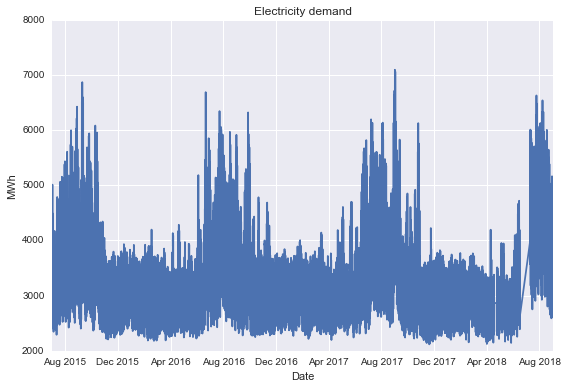

In [5]:
fig,ax = plt.subplots()
ax.plot(df['demand'])
ax.set_title('Electricity demand')
ax.set_ylabel('MWh')
ax.set_xlabel('Date')
plt.tight_layout()
plt.show()

As shown above, demand does indeed increase during the summer seasons, and exhibits a near-periodic behavior. Since demand is the feature we would like to eventually predict, we want to isolate weather features that strongly correlate with demand. One such feature is the cooling degree days. Cooling degree days are defined as the number of degrees above 65 degrees F per day, so they can be thought of as a measure of the cooling needed to retain a certain temperature, and thus as a strong proxy for electricity demand. Let's build a scatter plot of cooling degree days versus demand and look at the fit.

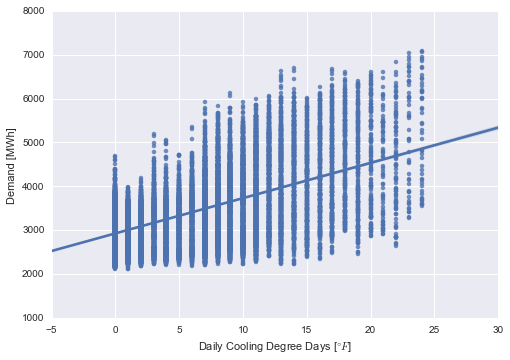

In [7]:
fig,ax = plt.subplots()
sns.regplot('dailycoolingdegreedays', 'demand', data=df, ax=ax)
ax.set_xlabel(r'Daily Cooling Degree Days [$\degree F$]')
ax.set_ylabel(r'Demand [MWh]')

Indeed, we see a positive correlation between cooling degree days and electricity demand. Further, we may wish to see how all of our weather features correlate with the variable we're trying to predict: electricity demand.

In [8]:
# Let's look at the correlations between electricity demand and the other variables to find trends
print('Demand correlations (Pearson)')
print(df.corr()['demand'].sort_values(ascending=False)[1:])

Demand correlations (Pearson)
dailycoolingdegreedays    0.572275
hourlydewpointtempf       0.383226
hourlyrelativehumidity    0.365116
hourlywetbulbtempf        0.302208
hourlycoolingdegrees      0.192912
hourlydrybulbtempf        0.044278
hourlyvisibility          0.009670
hourlyprecip             -0.022645
dailyheatingdegreedays   -0.221475
hourlywindspeed          -0.232047
hourlystationpressure    -0.265702
hourlysealevelpressure   -0.266134
hourlyaltimetersetting   -0.267439
hourlyheatingdegrees     -0.290998
Name: demand, dtype: float64


As expected, we see positive correlations with cooling degrees and negative correlations with heating degrees. From these trends we might hypothesize to see an even stronger correlation between demand and cooling degree days during the month of August. Let's check this hypothesis.

In [12]:
df_august = df[df.index.month == 8]
print('Demand correlations in August (Pearson)')
print(df_august.corr()['demand'].sort_values(ascending=False)[1:])

Demand correlations in August (Pearson)
hourlyrelativehumidity    0.588783
dailycoolingdegreedays    0.386745
hourlydewpointtempf       0.245938
hourlyheatingdegrees      0.112313
hourlyvisibility          0.005025
hourlysealevelpressure   -0.091701
hourlyaltimetersetting   -0.097325
hourlystationpressure    -0.100007
hourlywetbulbtempf       -0.224509
hourlycoolingdegrees     -0.233220
hourlywindspeed          -0.407909
hourlydrybulbtempf       -0.456495
hourlyprecip                   NaN
dailyheatingdegreedays         NaN
Name: demand, dtype: float64


Interestingly, although we see the correlation between cooling degree days increase, we also see relative humidity becoming a more significant correlation. Does this make sense? Intuitively, humidity is more prevalent during the summer season. Let's plot timestreams of relative humidity and demand together for a single year.

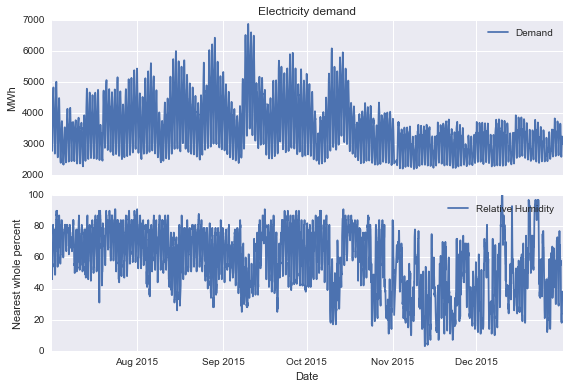

In [20]:
fig,ax = plt.subplots(2, sharex=True)
ax[0].plot(df['demand'][df.index.year == 2015], label='Demand')
ax[0].set_title('Electricity demand')
ax[0].set_ylabel('MWh')
ax[1].plot(df['hourlyrelativehumidity'][df.index.year == 2015], label='Relative Humidity')
ax[1].set_ylabel('Nearest whole percent')
ax[1].set_xlabel('Date')
ax[1].legend()
ax[0].legend()
plt.tight_layout()
plt.show()

It seems spikes in demand are correlated with spikes in relative humidity, although relative humidity appears to have a high standard deviation regardless.

Let's investigate features with high standard deviations relative to their means. Let's unpack summary statistics into a dataframe for more effective sorting and visualization.

In [18]:
stds = df.std()
means = df.mean()
medians = df.median()

df_stats = pd.DataFrame({'std': stds, 'mean': means, 'median': medians})
print(df_stats.sort_values('std', ascending=False))

                               mean   median         std
demand                  3317.094400  3191.00  785.756576
hourlyrelativehumidity    62.482905    66.00   20.829641
hourlydewpointtempf       51.144188    54.00   11.886757
hourlydrybulbtempf        66.454703    66.00    9.638729
hourlywetbulbtempf        58.249122    59.00    7.749118
hourlyheatingdegrees       7.371355     6.00    6.932305
dailycoolingdegreedays     4.866420     2.00    5.595377
dailyheatingdegreedays     1.971355     0.00    3.554354
hourlywindspeed            1.623656     0.00    2.415391
hourlyvisibility           9.220403    10.00    1.796501
hourlycoolingdegrees       0.651968     0.00    1.617127
hourlyaltimetersetting    29.967976    29.96    0.110782
hourlystationpressure     29.772348    29.76    0.108847
hourlysealevelpressure    29.964036    29.95    0.106616
hourlyprecip               0.000552     0.00    0.007481


As noted, relative humiditiy does seem to have a high standard deviation relative to the mean. Let's look at the the histogram and violin plot of relative humidity to get a better visual representation.

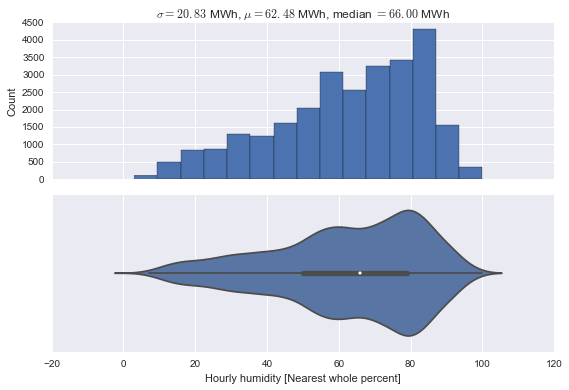

In [21]:
fig,ax = plt.subplots(2, sharex=True)
plot_data = df['hourlyrelativehumidity']
ax[0].hist(plot_data, bins=15)
title_text = r'$\sigma = %.2f$ MWh, $\mu = %.2f$ MWh, median $= %.2f$ MWh' % (plot_data.std(), plot_data.mean(), plot_data.median())
sns.violinplot(plot_data, ax=ax[1])
ax[0].set_ylabel('Count', labelpad=5)
ax[1].set_xlabel('Hourly humidity [Nearest whole percent]')
ax[0].set_title(title_text, size=12)
plt.tight_layout()

So although the standard deviation of hourly humiditity is relatively high, there are no obvious outliers indicating that the feature is accurate and still well-suited for prediction.